# Step 2: Training SAWYER's Reward Model using Human Preferences

In [ ]:
import os
from random import sample
from tqdm import tqdm

import torch
import numpy as np
import torch.nn as nn
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.utils import PaddingStrategy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


Using device: cuda



comparison_data_v2.json ranked responses from LLMs including:

1. GPT-4
2. GPT-3.5
3. OPT-IML
4. DaVinci (InstructGPT)

by asking GPT-4 to rate the quality.

Each data element has keys:

- user_input: str, prompts used for quering LLMs.
- responses_and_scores: list[str], list of
    - response: the response from the LLM
    - source: the LLM that generated the response
    - score: Score given to the response (from GPT-4)
    
    
See more info [here](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/tree/main#how-good-is-the-data)

In [ ]:
import huggingface_hub, os
from google.colab import userdata

huggingface_hub.login(token=userdata.get('HF_TOKEN'))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import pandas

comparison_data = pandas.read_json('https://raw.githubusercontent.com/sinanuozdemir/quick-start-guide-to-llms/main/data/comparison_data_v2.json')

In [ ]:
comparison_data.iloc[0]

user_input              Below is an instruction that describes a task....
responses_and_scores    [{'response': '1.Eat a balanced diet and make ...
Name: 0, dtype: object

In [ ]:
comparison_data.head()

,user_input,responses_and_scores
0,Below is an instruction that describes a task....,[{'response': '1.Eat a balanced diet and make ...
1,Below is an instruction that describes a task....,[{'response': 'The three primary colors are re...
2,Below is an instruction that describes a task....,[{'response': 'An atom is made up of a nucleus...
3,Below is an instruction that describes a task....,[{'response': 'There are a number of ways to r...
4,Below is an instruction that describes a task....,[{'response': 'I had to make a difficult decis...


In [ ]:
print(comparison_data.iloc[0]['user_input'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.


In [ ]:
comparison_data.iloc[0]['responses_and_scores']

[{'response': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
  'score': 9.0,
  'source': 'text-davinci-003'},
 {'response': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune func

In [ ]:
def get_score_tuples(dictionary):
    responses = dictionary['responses_and_scores']
    tuples = []

    for i in range(len(responses)):
        for j in range(i + 1, len(responses)):
            response_i = responses[i]
            response_j = responses[j]
            score_i = response_i['score']
            score_j = response_j['score']

            if (score_i - score_j) > 0:
                score_difference = score_i - score_j
                tuples.append(((response_i['response'], score_i), (response_j['response'], score_j), score_difference))

    return tuples


In [ ]:
new_examples = []
for i, row in tqdm(comparison_data.iterrows(), total=comparison_data.shape[0]):
    for pair in get_score_tuples(row):
        new_examples.append({
            'instruction': row['user_input'].split('### Instruction:\n')[-1].replace('### Input:\n', ''),
            'text_j': pair[0][0],
            'text_k': pair[1][0],
            'score_diff': pair[2]
        })

100%|██████████| 52001/52001 [00:02<00:00, 18986.86it/s]


In [ ]:
len(new_examples)

95147

In [ ]:
sample(new_examples, 1)

[{'instruction': 'Summarize the essay "The Value of Games and Sport"',
  'text_j': 'The essay "The Value of Games and Sport" explores the benefits that come from engaging in physical activities such as sports and games. It argues that these activities have the potential to foster physical health, cognitive development, and social skills. Moreover, engaging in these activities can be a great source of fun, relaxation, and proper exercise. It is concluded that playing games and participating in sports has the ability to positively influence the mental and physical well-being of individuals.',
  'text_k': 'I will summarize the essay "The Value of Games and Sport"',
  'score_diff': 5.0}]

In [ ]:
from datasets import Dataset

pairs_dataset = Dataset.from_list(new_examples)
pairs_dataset = pairs_dataset.train_test_split(train_size=.8, seed=42)
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 19030
    })
})

In [ ]:
pairs_dataset['test'][0]

{'instruction': 'How did the Battle of Gettysburg change the course of the American Civil War?',
 'text_j': 'The Battle of Gettysburg, fought from July 1 to July 3 1863, is considered one of the most important and decisive battles in the American Civil War as it marked a major turning point in the conflict. Before the battle, the Confederate army, commanded by General Robert E. Lee, had been enjoying a string of victories and launched an invasion of the Northern states, hoping that a major victory on Northern soil would demoralize the Union and force them to seek peace. However, the Union army, led by General George G. Meade, was able to successfully repel the Confederate attack in a bloody and costly battle, with an estimated 23,000 Union and 28,000 Confederate casualties.\n\nThe Union victory at Gettysburg, along with the capture of the Confederate stronghold of Vicksburg on July 4 1863, changed the momentum of the war in favor of the Union. The Confederate army was forced to retreat

In [ ]:
# Using a cross-encoder to encode question and answer together to produce a score
#  This is an expected use-case for a cross-encoder

model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config = AutoConfig.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=1,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Turn the dataset into pairs of input + output, where text_j is the preferred question + answer and text_k is the other.
# Then tokenize the dataset.
def preprocess_function(example):
    new_examples = {
        "input_ids_j": [],
        "attention_mask_j": [],
        "input_ids_k": [],
        "attention_mask_k": [],
        "score_diff": []
    }

    new_examples['score_diff'].append(example['score_diff'])
    question = example["instruction"]
    tokenized_j = tokenizer(question, example['text_j'], truncation=True)
    tokenized_k = tokenizer(question, example['text_k'], truncation=True)

    new_examples["input_ids_j"].append(tokenized_j["input_ids"])
    new_examples["attention_mask_j"].append(tokenized_j["attention_mask"])
    new_examples["input_ids_k"].append(tokenized_k["input_ids"])
    new_examples["attention_mask_k"].append(tokenized_k["attention_mask"])

    return new_examples

# preprocess the dataset and filter out QAs that are longer than max_length
pairs_dataset = pairs_dataset.map(preprocess_function, batched=False)


Map:   0%|          | 0/76117 [00:00<?, ? examples/s]

Map:   0%|          | 0/19030 [00:00<?, ? examples/s]

In [ ]:
pairs_dataset.set_format('pt')

In [ ]:
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 19030
    })
})

In [ ]:
pairs_dataset['train'][5]

{'instruction': 'Write an article about climate change.',
 'text_j': "Climate change is one of the most pressing and urgent issues of the modern world. It is an ever-evolving environmental threat that threatens the planet's future, especially with regards to the natural environment that we as humans depend upon. Over the decades, the scientific community has recorded a consistent and steady rise in global temperatures that can only be attributed to the increasing concentrations of Greenhouse gases in the atmosphere due to our continued burning of fossil fuels. This has sparked a chain reaction of catastrophic events that is wreaking havoc on the planet, such as extreme weather events, melting of polar ice caps and the ocean rising to unprecedented levels, threatening the future of entire cities and coastal areas.\n\nThe urgency of this global crisis is only compounded by the fact that climate change is happening much faster than predicted. This means that in order to maintain a livable

In [ ]:
# We need to define a special data collator that batches the data in our j vs k format.
import evaluate

@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append(
                {
                    "input_ids": feature["input_ids_j"].squeeze(),
                    "attention_mask": feature["attention_mask_j"].squeeze(),
                }
            )
            features_k.append(
                {
                    "input_ids": feature["input_ids_k"].squeeze(),
                    "attention_mask": feature["attention_mask_k"].squeeze(),
                }
            )
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "score_diff": [feature['score_diff'] for feature in features],
            "return_loss": True,
        }
        return batch

# Define the metric that we'll use for validation.
accuracy = evaluate.load("accuracy")


In [ ]:
RewardDataCollatorWithPadding

__main__.RewardDataCollatorWithPadding

In [ ]:
def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # Here, predictions is rewards_j and rewards_k.
    # We want to see how much of the time rewards_j > rewards_k.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape)
    return accuracy.compute(predictions=predictions, references=labels)

# We are subclassing the Hugging Face Trainer class to customize the loss computation
class RewardTrainer(Trainer):
    # Overriding the compute_loss function to define how to compute the loss for our specific task
    def compute_loss(self, model, inputs, return_outputs=False):
        # Calculate the reward for a preferred response y_j using the model. The input IDs and attention masks for y_j are provided in inputs.
        rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]

        # Similarly, calculate the reward for a lesser preferred response y_k.
        rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]

        # Calculate the loss using the negative log-likelihood function.
        # We take the difference of rewards (rewards_j - rewards_k) and subtract from it the score difference provided in the inputs.
        # Then, we apply the sigmoid function (via torch.nn.functional.logsigmoid) and negate the result.
        # The mean loss is calculated across all examples in the batch.

        loss = -nn.functional.logsigmoid((rewards_j - rewards_k - torch.tensor(inputs['score_diff'], device=rewards_j.device))).mean()

        # If we also want to return the outputs (rewards for y_j and y_k) along with the loss, we do so.
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}

        # Otherwise, we simply return the computed loss.
        return loss


In [ ]:
import wandb
# Set up Weights and Biases integration
wandb.init(project="sawyer-reward")

wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


In [ ]:
training_args = TrainingArguments(
    output_dir='sawyer_rm',
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    num_train_epochs=3,

    evaluation_strategy="epoch",
    save_strategy="epoch",

    remove_unused_columns=False,
    label_names=[],
    fp16=True if device.type == 'cuda' else False,
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=1e-6,
    warmup_ratio=0.1,
    push_to_hub=True,
    hub_model_id="profoz/sawyer-reward",
    hub_strategy="every_save",
)

# Train the model, woohoo.
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=pairs_dataset['train'],
    eval_dataset=pairs_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(
        tokenizer=tokenizer),
)

trainer.evaluate()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 5.016231060028076,
 'eval_accuracy': 0.3722017866526537,
 'eval_runtime': 237.2827,
 'eval_samples_per_second': 80.2,
 'eval_steps_per_second': 2.508}

In [ ]:
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
0,0.670500,0.606224,0.964530
1,0.389200,0.475221,0.970100
2,0.418000,0.446066,0.971886


TrainOutput(global_step=7134, training_loss=1.0500664492598561, metrics={'train_runtime': 7728.2912, 'train_samples_per_second': 29.547, 'train_steps_per_second': 0.923, 'total_flos': 0.0, 'train_loss': 1.0500664492598561, 'epoch': 3.0})

In [ ]:
# !huggingface-cli login
# !huggingface-cli repo create sawyer-reward


In [ ]:
username, repo_name = 'profoz', 'sawyer-llama-reward'

# Push model and tokenizer to Hugging Face Hub
trainer.model.push_to_hub(f"{username}/{repo_name}")
tokenizer.push_to_hub(f"{username}/{repo_name}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/profoz/sawyer-llama-reward/commit/c524e64592ed7f4b5975fc766d9c548999a6eca3', commit_message='Upload tokenizer', commit_description='', oid='c524e64592ed7f4b5975fc766d9c548999a6eca3', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
username, repo_name = 'profoz', 'sawyer-llama-reward'

pipe = pipeline("text-classification", model=f"{username}/{repo_name}", function_to_apply='none')

def test_reward_pipeline(query, response):
    return pipe(
        [
            {
                "text": query,
                "text_pair": response
            }
        ],
    )[0]['score']

config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
# an example where I'd expect positive
test_reward_pipeline(
    'Give three tips for staying healthy.',
    'Eat healthy, exercise, and sleep.'
    )

-7.213021278381348

In [ ]:
# an example where I'd expect positive
test_reward_pipeline('how do I greet someone?', 'Tell them Hello!')

-5.177160739898682

In [ ]:
# Hmm, longer seems to be more rewarded?
test_reward_pipeline('how do I greet someone?', 'To greet someone, try telling them Hello!')

4.9220404624938965

In [ ]:
# the more I ramble the more I seem to get rewarded. Let's keep this in mind
test_reward_pipeline('how do I greet someone?', 'To greet someone, try telling them Hello! If you want more information, '
                                    'here are three more ways to greet someone:\n1. Ask how their day is\n2. Comment on the weather\n3. '
                                    'Tell them they look nice today')


7.610815048217773

In [ ]:
# another example where I'd expect negative
test_reward_pipeline('how do I greet someone?', 'Tell them to frick off!')

-5.161818504333496

In [ ]:
# another example where I'd expect negative for being irrelevant
test_reward_pipeline('Who throws the football the most often?', 'Tell them Hello!')

-0.6070520877838135

In [ ]:
# another example where I'd expect negative because it's irrelevant. That's why I wanted those synthetic examples in there
test_reward_pipeline('Who throws the football the most often?', 'Football could refer to many things.')

-4.354253768920898

In [ ]:
test_reward_pipeline('What is an option in finance?', 'What even is a car?')

-6.8216328620910645

In [ ]:
p = pairs_dataset['test'][10]

print(p['instruction'])
print('J\n------')
print(p['text_j'])
print('K\n-------')
print(p['text_k'])
print(p['score_diff'])




Write a list of creative holiday gift ideas for someone who already has a lot of things.
J
------
1. Customized photo album or scrapbook: Fill it with personal memories and favorite moments from the past year.

2. Experience gift: Treat them to a special outing or adventure, such as tickets to a concert, hot air balloon ride, or a cooking class.

3. Personalized gift: Consider a monogrammed item such as a piece of jewelry, luggage tag, or mug.

4. Gourmet food or drink: Indulge their taste buds with a basket of fine cheeses, artisan chocolates, or a selection of craft beers.

5. Subscription service: Gift them a subscription to a monthly book, coffee, or beauty box.

6. Handmade item: Give them a one-of-a-kind item such as a hand-knitted scarf, homemade bath products, or a piece of original artwork.

7. Charitable donation: Make a donation in their name to a charity or cause that is close to their heart.

8. Relaxation gift: Help them unwind with a gift certificate for a massage, spa d

In [ ]:
test_reward_pipeline(p['instruction'], p['text_j'])

7.738592147827148

In [ ]:
test_reward_pipeline(p['instruction'], p['text_k'])

-7.501391410827637

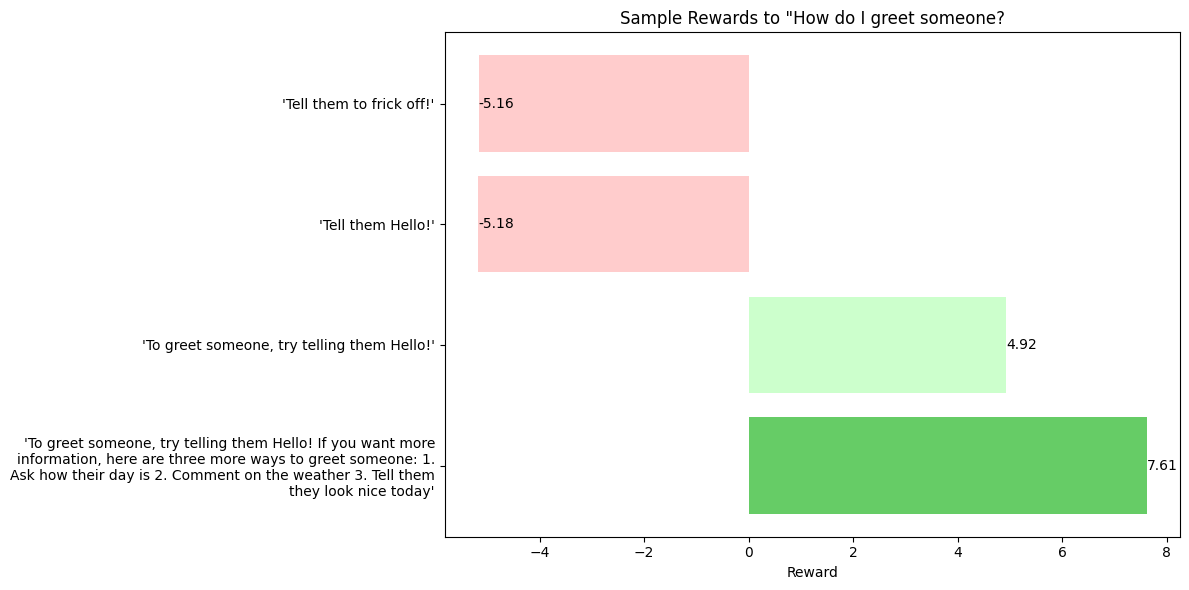

In [ ]:
# Plot each value as a separate bar and label them with the corresponding text
import matplotlib.pyplot as plt
import numpy as np

# Define the values and labels from the screenshot
values = [-5.161818504333496, -5.177160739989682, 4.9220404624938965, 7.610815048217773][::-1]
labels = [
    "'Tell them to frick off!'",
    "'Tell them Hello!'",
    "'To greet someone, try telling them Hello!'",
    "'To greet someone, try telling them Hello! "
    "If you want more information, here are three more ways to greet someone:\n"
    "1. Ask how their day is\n2. Comment on the weather\n3. Tell them they look nice today'"
][::-1]
# Wrap the text for each label so it does not extend too far horizontally

# Define a function to wrap text
def wrap_text(text, width):
    """
    A simple function to wrap text to a specified width.
    """
    from textwrap import wrap
    return '\n'.join(wrap(text, width))

# Apply text wrapping to each label
wrapped_labels = [wrap_text(label, 60) for label in labels]

# Re-create the figure with wrapped text labels
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the values
colors = ['#ffcccc', '#ffcccc', '#ccffcc', '#66cc66'][::-1]  # light red, light green, darker green

bars = ax.barh(range(len(values)), values, color=colors)

# Set the labels for each bar with wrapped text
ax.set_yticks(range(len(values)))
ax.set_yticklabels(wrapped_labels)

# Set the x-axis label
ax.set_xlabel('Reward')

# Set the title of the plot
ax.set_title('Sample Rewards to "How do I greet someone?')

# Add the text labels next to the bars
for bar, v in zip(bars, values):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(round(v, 2)),
            va='center', ha='left')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

